<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/OmegaConstant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
import numpy as np 
import csv
import os 
import cv2
from google.colab.patches import cv2_imshow
import numpy as np


In [0]:
##ADD A DIRECTORY CONTAINING THE SET OF IMAGES

!unrar e '/content/drive/My Drive/data.rar'


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
im_ohaze = []
im_our =[]

source = os.listdir('/content/')
for file in source:
  if(file.endswith('.jpg')):
    if 'outdoor' in file:
      im_ohaze.append(file)
    else:
      im_our.append(file)

In [0]:
our_img_label=[]
with open('/content/our_img_new.csv') as file:
  reader = csv.reader(file, delimiter = ',')
  for row in reader:
    l=[]
    l.append(row[0])
    l.append(row[1])
    our_img_label.append(l)

In [0]:
im_our.sort()
temp=[]


final_our={}

for i in our_img_label:
  for im in im_our:
    if(i[0]==im[:-4]):   
      final_our[im]=i[1]
     

In [0]:
##ADD THE LABELS (The estimated haze degree) in place of OHAZE_LABELS _NEW.csv

ohaze=[]

with open('/content/OHAZE_LABELS _NEW.csv') as file:
  reader = csv.reader(file)
  for row in reader:
    l=[]
    l.append(row[0])
    l.append(row[1])
    ohaze.append(l)

In [0]:
ohaze_labels={}

for i in ohaze:
  for im in im_ohaze:
    if 'GT' in im:
      if(im[0:3]+im[-6:-4])==i[0]:
        ohaze_labels[im]=i[1]
    elif(im[0:2] + im[-9:-4])==i[0]:
        ohaze_labels[im]=i[1]


In [0]:
##ADDING MORE DIVERSE IMAGES (Imported Dataset)

temp=[]

s = os.listdir('/content/drive/My Drive/Omega/Images/shanghai haze/')
for file in s:
  temp.append('/content/drive/My Drive/Omega/Images/shanghai haze/' + file)
  

newt=[]

s = os.listdir('/content/drive/My Drive/Omega/Images/Beijing/')
for file in s:
  newt.append('/content/drive/My Drive/Omega/Images/Beijing/' + file)
  
newt.sort()
beijing=newt

In [0]:

i=0
beijing_labels={}

with open('/content/beijing_labels.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    beijing_labels[beijing[i]]=row[0]
    i+=1
    

In [0]:
shanghai_labels=[]

temp.sort()
shanghai=temp

In [0]:
## ADD RESPECTIVE LABELS FILE 

shanghai_labels={}
i=0
with open('/content/shanghai_labels.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    shanghai_labels[shanghai[i]]=row[0]
    i+=1


In [0]:

print(len(beijing_labels))
print(len(shanghai_labels))
print(len(ohaze_labels))
print(len(final_our))

44
94
46
27


In [0]:

images =[]
for key in beijing_labels:
  images.append(key)
for key in shanghai_labels:
  images.append(key)
for key in ohaze_labels:
  images.append(key)
for key in final_our:
  images.append(key)
  

In [0]:

labels =[]
for key in beijing_labels:
  labels.append(beijing_labels[key])
for key in shanghai_labels:
  labels.append(shanghai_labels[key])
for key in ohaze_labels:
  labels.append(ohaze_labels[key])
for key in final_our:
  labels.append(final_our[key])
  

In [0]:
omega = []
for l in labels:
  if(l == '0'):
    omega.append(0.1)
  elif(l == '1'):
    omega.append(0.3)
  elif(l == '2'):
    omega.append(0.5)
  elif(l == '3'):
    omega.append(0.7)
  elif(l == '4'):
    omega.append(0.8)
  elif(l == '5'):
    omega.append(0.9)

In [0]:
## ACTUAL IMPLEMENTATION OF THE CONSTANT DETERMINATION 

ctr=0

x2_l=[]
x1_l=[]


for img in images:
  im = cv2.imread(img)
  im = cv2.resize(im, (1024,1024))
  B=np.zeros((1024,1024))
  D=np.zeros((1024,1024))
  C=np.zeros((1024,1024))
  # 3rd channel or im[2] has been split as b,g,r 

  b,g,r = cv2.split(im)

  ctr+=1
  for i in range(b.shape[0]):
    for j in range(b.shape[1]):
      D[i][j] = min(b[i][j], g[i][j], r[i][j])
      B[i][j] = max(b[i][j], g[i][j], r[i][j])
      C[i][j] = B[i][j] - D[i][j]

  d = np.sum(D)/float(np.size(D))
  b = np.sum(B)/float(np.size(B))
  c = b-d 
  A = (0.33)*max(np.ndarray.flatten(B)) + (0.66)*b
  
  x1_l.append((A - d)/float(A)) 
  x2_l.append(c/float(A)) 
  print(ctr)

In [0]:
print(len(x1_l))
print(len(x2_l))

211
211


In [0]:
## SPLITTING DATA INTO TESTING AND TRAINING DATA 

x1_train=x1_l[:150]
x1_train = np.resize(x1_train, (150,1))
x2_train=x2_l[:150]
x2_train = np.resize(x2_train, (150,1))

x1_test=x1_l[150:]
x1_test = np.resize(x1_test, (150,1))
x2_test=x2_l[150:]
x2_test = np.resize(x2_test, (150,1))

y_train=omega[:150]
y_train = np.resize(y_train, (150,1))
y_test=omega[150:]
y_test = np.resize(y_test, (150,1))

In [0]:
## DETERMINING THE CONSTANTS u,v,s

x1=tf.placeholder(dtype = tf.float32, shape = (None,1))
x2=tf.placeholder(dtype = tf.float32, shape= (None,1))
w=tf.placeholder(dtype = tf.float32, shape= (None,1))

train =[]
val =[]
u =tf.Variable(5.1)
v =tf.Variable(2.9)
s =tf.Variable(0.2461)
h = tf.math.exp(-0.5*(u*x1 + v*x2)+s)

loss = tf.reduce_mean(tf.square(tf.subtract(w,h)), name = 'loss')
opt = tf.train.AdamOptimizer(learning_rate = 0.001)
train_op = opt.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(30000):
    z = sess.run([loss,train_op, u, v, s],feed_dict={x1 :x1_train,x2 : x2_train, w : y_train })
    

In [0]:
## RESULT --> Final loss followed by the 3 constants u,v,s

print(z[0])
print(z[2])
print(z[3])
print(z[4])

0.053078476
10.087694
-8.1444645
0.15933125


Test Iterations 


## *FIRST* ITERATION 
u = 12.25592
v = -9.196996
s = 0.32244098

## SECOND ITERATION 
u = 10.127489
v= -8.336512
z = 0.13606234

## THIRD ITERATION 

Read the image as 1024, 1024 
u = 10.087694
v = -8.1444645
z = 0.15933125

## TESTING THE OBTAINED VALUES 

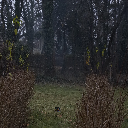

pred           0.0736030540700583
actual         [0.3]


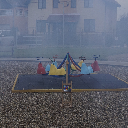

pred           0.3725088996208109
actual         [0.5]


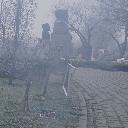

pred           0.5269529364547054
actual         [0.7]


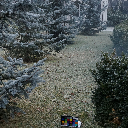

pred           0.16052939238371328
actual         [0.3]


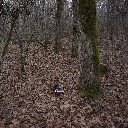

pred           0.12337589564793526
actual         [0.3]


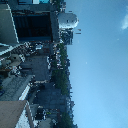

pred           0.2967100599132363
actual         [0.1]


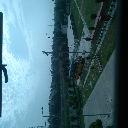

pred           0.24572022538926375
actual         [0.1]


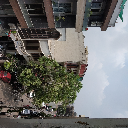

pred           0.26291896741175225
actual         [0.1]


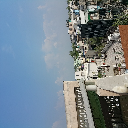

pred           0.38703858453870255
actual         [0.1]


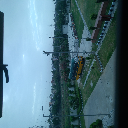

pred           0.2777148773857627
actual         [0.1]


In [0]:
u = 10.087694
v = -8.1444645 
s = 0.15933125

import math

i=0
k=0 
for img in images[150:]:
  im = cv2.imread(img)
  im = cv2.resize(im, (128,128))
  k+=1
  if(k%6==0):
    cv2_imshow(im)
    x1=x1_test[i]
    x2=x2_test[i]
    w = math.exp(-0.5*(u*x1 + v*x2)+s)
    print('pred           ' + str(w))
    ##Note that predictions will be mapped to a value between 0.1 - 0.9
    ##So 0.0736 will be mapped to 0.1 and so on
    print('actual         ' + str(y_test[i]))
  i+=1  
